# Stellar Classification using Photometric data

# Summary

# Introduction

Current and future astronomical surveys will observe hundred of thousands of objects each year. Due to the massive amount of spectroscopic and photometric data produced, an automated stellar classification process has become important in the field of astronomy in the past few years.

In astronomy, understanding the spectral characteristics of celestial objects serves as a fundamental pillar for unraveling the mysteries of the cosmos. Spectral classification, a cornerstone of astronomical research, enables us to discern the chemical composition, temperature, and evolutionary stage of stars, galaxies, and other celestial bodies. In the earliest days it was based on mass and temperature; however, our modern classification system has evolved and we classify stars based on the *Morgan–Keenan (MK)* system (Morgan et al. 1943) which group stars into 7 classes based on their spectral characteristics. Under the MK system, astronomers analyse electromagnetic radiation from stars to determine its class. These electromagnetic spectrum have dark lines to determine which and how abundant elements are present in the star. The 7 classes in the MK system - *O, B, A, F, G, K*, and *M* - are sequenced from the hottest (*O* type) to the coolest (*K* type) which also exhibits a certain characteristic that is very visible - colour. Hence in this report, we will classify stars using photometric data and in the Discussion section, we will evaluate whether this is a reliable alternative for the traditional method of comparing the best fit of the spectra to that of templates using statistical tests (Duan et al. 2009).

## Definitions

**Photometry**: the measurement of the flux or intensity of an astronomical object's electromagnetic radiation

The photometric system we're using to classify star types is the *Sloan* system (add reference) used by the Sloan Digital Sky Survey. The system measures the intensity of electromagnetic radition from stars at 5 bands:
- *u* (345nm)
- *g* (475nm which is a light blue in the visible spectrum)
- *r* (622nm which is orange)
- *i* (763nm which is deep red)
- *z* (905nm)

# Methods & Results

## Data

This report has made use of the NASA Exoplanet Archive, which is operated by the California Institute of Technology, under contract with the National Aeronautics and Space Administration under the Exoplanet Exploration Program. NASA Exoplanet Archive collects data from various sources, including ground-based observatories and space telescopes such as the Kepler Space Telescope and the Transiting Exoplanet Survey Satellite (TESS). The dataset is we're using is their [Planetary Systems dataset](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS) which has the columns of names, spectral type and measurements using Sloan photometric system selected.

The Python programming language (Van Rossum and Drake, 2009) and the following Python packages were used to perform the analysis: matplotlib (Hunter, 2007), scikit-learn (Pedregosa et al., 2011) and Pandas (McKinney, 2010).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

exoplanet_data = pd.read_csv('data/2024-03-01-exoplanet_dataset.csv', 
                             header = 13,
                             dtype = {'pl_name' : 'string', 'st_spectype' : 'string'})
with pd.option_context('display.max_rows', 6,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.precision', 3,
                       'display.colheader_justify', 'center'):
    display(exoplanet_data)

,pl_name,st_spectype,sy_umag,sy_gmag,sy_rmag,sy_imag,sy_zmag
0,11 Com b,<NA>,NaN,NaN,NaN,NaN,NaN
1,11 Com b,G8 III,NaN,NaN,NaN,NaN,NaN
2,11 Com b,G8 III,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
35845,xi Aql b,<NA>,NaN,NaN,NaN,NaN,NaN
35846,xi Aql b,<NA>,NaN,NaN,NaN,NaN,NaN
35847,xi Aql b,K0 III,NaN,NaN,NaN,NaN,NaN


This dataset from NASA's Exoplanet Archive include all planets and stars. Therefore we will wrangle the dataset such that it only contain stars with Sloan magnitudes for photometric measurements.

Variables:

`st_spectype`: Classification of the star based on their spectral characteristics following the Morgan-Keenan system

`sy_umag`: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) u band, in units of magnitudes

`sy_gmag`: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) g band, in units of magnitudes

`sy_rmag`: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) r band, in units of magnitudes

`sy_imag`: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) i band, in units of magnitudes

`sy_zmag`: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) z band, in units of magnitudes

In [2]:
stars_data = exoplanet_data.dropna(subset = ['st_spectype',
                                             'sy_umag',
                                             'sy_gmag',
                                             'sy_rmag',
                                             'sy_zmag'])
stars_data["st_spectype"] = stars_data['st_spectype'].transform(lambda x: x[0].upper())
only_stars_data = stars_data.loc[stars_data['st_spectype'].isin(['O','B', 'A', 'F', 'G', 'K', 'M'])]
only_stars_data["st_spectype"] = only_stars_data["st_spectype"].astype("category")

display(only_stars_data)

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_60256\1900484049.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_data["st_spectype"] = stars_data['st_spectype'].transform(lambda x: x[0].upper())
C:\Users\VietNgo\AppData\Local\Temp\ipykernel_60256\1900484049.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_stars_data["st_spectype"] = only_stars_data["st_spectype"].astype("category")


,pl_name,st_spectype,sy_umag,sy_gmag,sy_rmag,sy_imag,sy_zmag
180,BD+20 2457 b,K,14.9129,10.5155,9.277390,8.84049,8.97784
182,BD+20 2457 c,K,14.9129,10.5155,9.277390,8.84049,8.97784
183,BD+20 274 b,K,14.3374,10.1863,8.941711,8.49228,8.90440
210,BD-17 63 b,K,14.1468,10.2994,9.211040,8.86964,9.00956
215,CD Cet b,M,17.4608,15.0603,13.949400,14.18480,13.29560
...,...,...,...,...,...,...,...
35641,XO-1 b,G,14.8365,11.7844,11.049500,10.86850,11.31440
35701,XO-5 b,G,15.3529,15.0080,11.988900,11.82070,13.65610
35702,XO-5 b,G,15.3529,15.0080,11.988900,11.82070,13.65610
35703,XO-5 b,G,15.3529,15.0080,11.988900,11.82070,13.65610


## Exploratory Data Analysis

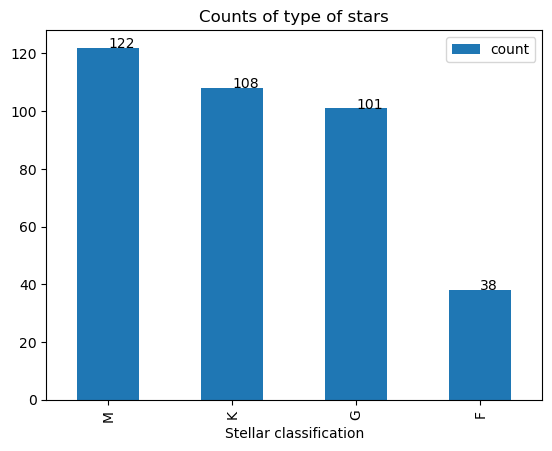

In [3]:
types_summ = pd.DataFrame(only_stars_data["st_spectype"].value_counts())

fig, ax = plt.subplots(1, 1)
types_summ.plot.bar(xlabel = 'Stellar classification', title="Counts of type of stars", ax=ax)

for col in types_summ.columns:
    for id, val in enumerate(types_summ[col]):
        ax.text(id, val, str(val))

There are only 4 classes of stars, *M*, *K*, *G*, *F*, with Sloan magnitudes in our datasets so our classification model can only classify stars into these 4 classes. Most of the stars fall within *M*, *K* and *G* classes

In [4]:
display(only_stars_data[['st_spectype', 'sy_umag']].groupby('st_spectype').describe())

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_60256\1402384793.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(only_stars_data[['st_spectype', 'sy_umag']].groupby('st_spectype').describe())


sy_umag                                                  \
              count       mean       std      min      25%      50%   
st_spectype                                                           
F              38.0  15.006642  0.766401  13.7542  14.7063  14.8961   
G             101.0  15.187605  0.517554  13.9531  15.0087  15.1660   
K             108.0  15.638826  0.853421  13.0932  15.0413  15.6091   
M             122.0  17.461141  1.806210  14.5112  15.7198  17.2832   

                                 
                   75%      max  
st_spectype                      
F            15.233200  17.9494  
G            15.486200  16.9794  
K            15.845975  17.9905  
M            19.150525  21.2975

For *M*-class of stars, the magnitude of the *u*-band is much higher than the remaining classes at 17.3 at the median.

In [5]:
display(only_stars_data[['st_spectype', 'sy_gmag']].groupby('st_spectype').describe())

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_60256\476728448.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(only_stars_data[['st_spectype', 'sy_gmag']].groupby('st_spectype').describe())


sy_gmag                                                      \
              count       mean       std       min        25%       50%   
st_spectype                                                               
F              38.0  13.402132  1.491581  10.76140  12.064725  13.24350   
G             101.0  13.383252  1.038540  10.49290  12.721300  13.30640   
K             108.0  13.208701  1.767100  10.01390  11.312600  13.52050   
M             122.0  14.902479  2.062624   9.91288  13.021000  15.30185   

                                 
                   75%      max  
st_spectype                      
F            14.971975  16.4513  
G            14.108400  15.3870  
K            14.894800  16.0648  
M            16.439975  18.7296

Again, for *M*-class of stars, the magnitude of the *g*-band is much higher than the remaining classes at 15.3 at the median.

In [6]:
display(only_stars_data[['st_spectype', 'sy_rmag']].groupby('st_spectype').describe())

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_60256\3279342249.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(only_stars_data[['st_spectype', 'sy_rmag']].groupby('st_spectype').describe())


sy_rmag                                                    \
              count       mean       std       min      25%       50%   
st_spectype                                                             
F              38.0  12.618895  1.189809  10.31190  11.6961  12.58465   
G             101.0  12.600822  1.094898   9.62924  11.9889  12.20680   
K             108.0  11.951414  1.701821   8.75954  10.5964  12.06500   
M             122.0  13.423811  2.001700   8.46313  11.6746  13.44375   

                                 
                   75%      max  
st_spectype                      
F            13.383525  15.7952  
G            13.115700  15.3971  
K            13.396700  15.6566  
M            15.271700  16.8600

Again, for *M*-class of stars, the magnitude of the *r*-band is higher than the remaining classes at 13.4 at the median.

In [7]:
display(only_stars_data[['st_spectype', 'sy_imag']].groupby('st_spectype').describe())

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_60256\413351714.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(only_stars_data[['st_spectype', 'sy_imag']].groupby('st_spectype').describe())


sy_imag                                                            \
              count       mean       std       min      25%      50%      75%   
st_spectype                                                                     
F              38.0  12.576882  1.308776  10.27340  11.6210  12.4579  13.1710   
G             101.0  12.403310  1.144568   9.44522  11.6309  11.9824  12.8354   
K             108.0  11.911296  1.565200   8.42724  10.4417  12.0708  13.1720   
M             122.0  12.689949  2.167585   7.75055  10.9702  12.9151  14.3142   

                      
                 max  
st_spectype           
F            15.4941  
G            16.6984  
K            14.5213  
M            17.9112

For every class of stars, the magnitude at the *i*-band is similar.

In [8]:
display(only_stars_data[['st_spectype', 'sy_zmag']].groupby('st_spectype').describe())

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_60256\2690570458.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(only_stars_data[['st_spectype', 'sy_zmag']].groupby('st_spectype').describe())


sy_zmag                                                      \
              count       mean       std       min        25%       50%   
st_spectype                                                               
F              38.0  13.088816  0.937463  10.47840  12.980800  13.17575   
G             101.0  12.970841  0.695333   9.60484  12.732600  13.04600   
K             108.0  11.921180  1.529773   7.85169  10.860600  12.65380   
M             122.0  12.175200  1.652974   7.76319  11.031975  12.71950   

                                 
                   75%      max  
st_spectype                      
F            13.463275  15.2871  
G            13.356600  14.4078  
K            13.240300  13.9587  
M            13.256500  15.1016

# Discussion

# References

- Morgan, W. W., Keenan, P. C., & Kellman, E. (1942). An atlas of stellar spectra. University of Chicago.
- Duan, F. Q., Liu, R., Guo, P., Zhou, M. Q., & Wu, F. C. (2009). Automated spectral classification using template matching. Research in Astronomy and Astrophysics, 9(3), 341.
- Van Rossum, G., & Drake Jr, F. L. (1995). Python tutorial (Vol. 620). Amsterdam, The Netherlands: Centrum voor Wiskunde en Informatica.
- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in science & engineering, 9(03), 90-95.
- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. the Journal of machine Learning research, 12, 2825-2830.
- McKinney, W. (2010, June). Data structures for statistical computing in python. In Proceedings of the 9th Python in Science Conference (Vol. 445, No. 1, pp. 51-56).